In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
import pandas as pd

# {"username":"nikaavdavd","key":"c02faca605035a6d75e6d0ecbb8d30e3"}
od.download( "https://www.kaggle.com/competitions/what-on-the-video")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikaavdavd
Your Kaggle Key: ··········


100%|██████████| 690M/690M [00:06<00:00, 104MB/s] 



Extracting archive ./what-on-the-video/what-on-the-video.zip to ./what-on-the-video


In [ ]:
train_csv_path = "/content/what-on-the-video/train.csv"
train_video_path = "/content/what-on-the-video/train"
test_video_path = "/content/what-on-the-video/test"

In [ ]:
train_df=pd.read_csv(train_csv_path)
train_df

,path,labels
0,port_before_sunrise_preview.mp4,sunset
1,Louisiana speeding boat on Mississippi River_p...,cloud
2,170509A_Vietnam_03_preview.mp4,water
3,Croatia water on rocks at high tide pan_previe...,water
4,Arizona zoom on sunset mountain_preview.mp4,sunset
...,...,...
285,bees2_preview.mp4,flower
286,170628_016_preview.mp4,food
287,_import_615fd719c295d0.10594294_preview.mp4,flower
288,_import_616e5ebb6151f5.55336006_preview.mp4,animal


In [ ]:
train_df['labels'] = train_df['labels'].str.replace('.',',')
train_df['labels'] = train_df['labels'].str.replace(' ','')
train_df['labels'] = train_df['labels'].fillna('').apply(lambda x: x.split(',') if x != '' else [])
train_df

,path,labels
0,port_before_sunrise_preview.mp4,[sunset]
1,Louisiana speeding boat on Mississippi River_p...,[cloud]
2,170509A_Vietnam_03_preview.mp4,[water]
3,Croatia water on rocks at high tide pan_previe...,[water]
4,Arizona zoom on sunset mountain_preview.mp4,[sunset]
...,...,...
285,bees2_preview.mp4,[flower]
286,170628_016_preview.mp4,[food]
287,_import_615fd719c295d0.10594294_preview.mp4,[flower]
288,_import_616e5ebb6151f5.55336006_preview.mp4,[animal]


In [ ]:
from itertools import chain

all_labels = set(chain.from_iterable(train_df['labels']))
print(sorted(all_labels))


['animal', 'car', 'cloud', 'dance', 'fire', 'flower', 'food', 'sunset', 'water']


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(train_df['labels'])

# labels_encoded — numpy array с one-hot кодировкой
# mlb.classes_ — список всех меток (колонки)

import pandas as pd

labels_df = pd.DataFrame(labels_encoded, columns=mlb.classes_)
train_df = pd.concat([train_df,labels_df],axis = 1)
train_df

,path,labels,animal,car,cloud,dance,fire,flower,food,sunset,water
0,port_before_sunrise_preview.mp4,[sunset],0,0,0,0,0,0,0,1,0
1,Louisiana speeding boat on Mississippi River_p...,[cloud],0,0,1,0,0,0,0,0,0
2,170509A_Vietnam_03_preview.mp4,[water],0,0,0,0,0,0,0,0,1
3,Croatia water on rocks at high tide pan_previe...,[water],0,0,0,0,0,0,0,0,1
4,Arizona zoom on sunset mountain_preview.mp4,[sunset],0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
285,bees2_preview.mp4,[flower],0,0,0,0,0,1,0,0,0
286,170628_016_preview.mp4,[food],0,0,0,0,0,0,1,0,0
287,_import_615fd719c295d0.10594294_preview.mp4,[flower],0,0,0,0,0,1,0,0,0
288,_import_616e5ebb6151f5.55336006_preview.mp4,[animal],1,0,0,0,0,0,0,0,0


<class 'cv2.VideoCapture'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


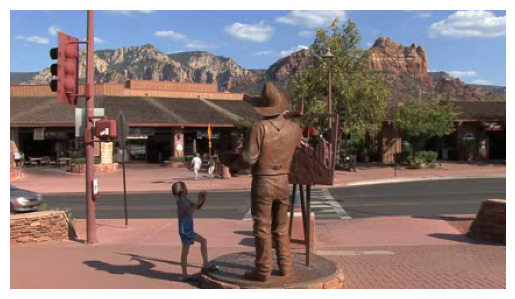

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
import cv2 as cv
from matplotlib import pyplot as plt

cap = cv.VideoCapture('/content/what-on-the-video/train/000690437-arizona-sedona-statue-cowboy-a_preview.mp4')
print(type(cap))

ret, frame = cap.read()
print(type(frame))

if ret:
    frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    print(type(frame_rgb))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()
else:
    print("Не удалось прочитать кадр из видео")

cap.release()

In [ ]:
import os
print(len(os.listdir(train_video_path )))

428


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np


class VideoDataset(Dataset):
    def __init__(self, dataframe, video_dir, transform=None, mode='train',num_frames = 5):

        self.dataframe = dataframe.reset_index(drop=True)
        self.video_dir = video_dir
        self.transform = transform
        self.mode = mode
        self.num_frames = num_frames

        if self.mode == 'train' or self.mode == 'val':
            if 'labels' not in self.dataframe.columns:
                raise ValueError("Dataframe must contain 'labels' column in train/val mode.")

    def __len__(self):
        return len(self.dataframe)

    def extract_frames(self, cap):
        total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
        if total_frames < self.num_frames:
            raise ValueError(f"Видео содержит только {total_frames} кадров, требуется минимум {self.num_frames}")

        frame_indices = np.linspace(0, total_frames - 1, self.num_frames, dtype=int)
        frames = []
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            if i in frame_indices:
                frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                if self.transform:
                    frame = self.transform(frame)
                frames.append(frame)
        return frames

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        vid_path = os.path.join(self.video_dir, row['path'])
        cap = cv.VideoCapture(vid_path)


        frames = self.extract_frames(cap)
        cap.release()
        if not ret:
            raise RuntimeError(f"Не удалось прочитать кадр из видео {vid_path}")
        video_tensor = torch.stack(frames)


        if self.mode in ['train', 'val']:
            caption = row.iloc[2:].astype(np.int32).values
            return video_tensor, torch.tensor(caption)
        else:
            return video_tensor

In [ ]:
#from sklearn.model_selection import train_test_split
#train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
#print(train_df.shape, val_df.shape)

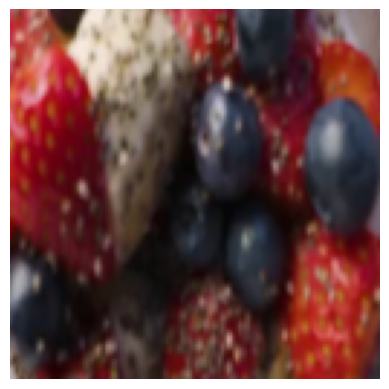

torch.Size([16, 9])
tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0]], dtype=torch.int32)
torch.Size([16, 5, 3, 128, 128])


In [ ]:
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])



train_dataset = VideoDataset(train_df, video_dir=train_video_path, transform=transform, mode='train')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



for frame, caption in train_loader:
    img = frame[0,0].permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(caption.shape)
    print(caption)
    print(frame.shape)
    break

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Simple3DCNN(nn.Module):
    def __init__(self, num_classes=2,hidden_size=128, num_layers=1):
        super(Simple3DCNN, self).__init__()
        resnext = models.resnext50_32x4d(pretrained=True)
        self.backbone = nn.Sequential(*list(resnext.children())[:-1])
        self.feature_dim = 2048

        self.gru = nn.GRU(input_size=self.feature_dim,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B, C, T, H, W = x.shape

        x = x.permute(0, 2, 1, 3, 4).contiguous()
        x = x.view(B * T, C, H, W)
        features = self.backbone(x)
        features = features.view(B, T, self.feature_dim)

        gru_out, _ = self.gru(features)
        last_output = gru_out[:, -1, :]
        out = self.fc(last_output)
        return torch.sigmoid(out)


In [ ]:
model = Simple3DCNN(num_classes=9).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        images = images.permute(0, 2, 1, 3, 4)
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(images)

        #print(outputs)
        #print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0
        #print(outputs)
        #print(labels)
        total += labels.size(0)*16
        correct += (outputs == labels).sum().item()

        #break

    acc = correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Accuracy: {acc:.4f}")

Epoch 1/5 - Loss: 2.1787 - Accuracy: 0.3649
Epoch 2/5 - Loss: 1.9252 - Accuracy: 0.4444
Epoch 3/5 - Loss: 1.8263 - Accuracy: 0.4938
Epoch 4/5 - Loss: 1.7531 - Accuracy: 0.5384
Epoch 5/5 - Loss: 1.7146 - Accuracy: 0.5517


**Обработка тестовых видео**


Датасет: состоит из 603 видео и описаний к ним. Сложности: нужно захватить последовательность из кадров, а не одну картинку, текст нужно векторизовать, частое повторение некоторых слов, разная длина описания, разная длина видео ( графики с распределением длины описания и видео)



Предобработка: обработка текста для упрощения токенизации, трансформации для кадров, извлеченных из видео, создание датасета, возвращающего по индексу и вектор описания и несколько кадров видео



Подходы: декодер использует lstm для перевода из контекстного вектора из энкодера в последовательность токенов, а энкодер был реализован как самописная 3DCNN(cреднее уменьшение потерь 0,5) и предобученный ResneXt (графики сравнения результатов с одной и со второй)  



Обучение: обучение в пять эпох передача в декодер выход с энкодера и его собственный скрытый слой, метрики: loss, avg_loss по батчам



Выводы: предобработанные умными людьми модели работают лучше самописных



Предложения: подключить норм сеть для сохранении грамматики языка

In [ ]:
test_df =[]
for filename in os.listdir(test_video_path):
  test_df.append(filename)

test_df = pd.DataFrame(test_df,columns=['path'])
print(len(os.listdir(test_video_path )))
test_df

435


,path
0,Arizona desert shrubs and clouds_preview.mp4
1,005495163-white-flower_preview.mp4
2,170411A_13_Blossom_1080p_preview.mp4
3,181015_15b_Venice Canals_HD_01_preview.mp4
4,Big leaf maple flowers zoom in_preview.mp4
...,...
430,170609_E_Varanasi_028_preview.mp4
431,040642316-montana-grass-fire-and-weeds-s_previ...
432,210112_01_Covid Oxford_4k_060_preview.mp4
433,Canada Hopewell Rocks Bay of Fundy big cloud j...


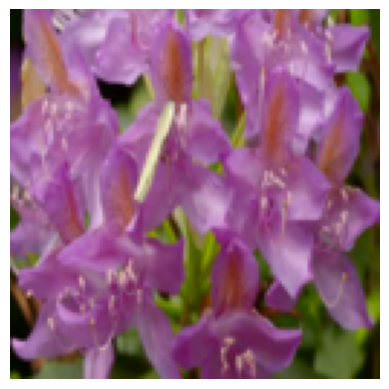

torch.Size([16, 5, 3, 128, 128])


In [ ]:
test_dataset = VideoDataset(test_df, video_dir=test_video_path, transform=transform, mode='test')
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

for frame in test_loader:
    img = frame[0,0].permute(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(frame.shape)
    break

In [ ]:
model.eval()
answers = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        images = images.permute(0, 2, 1, 3, 4)

        outputs = model(images)
        outputs[outputs > 0.5] = 1
        outputs[outputs <= 0.5] = 0

        outputs = outputs.detach().cpu().numpy()
        #print(outputs)
        answers.extend(outputs)
        #break



answers_df = pd.DataFrame(answers)
answers_df

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
430,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
431,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
432,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
433,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
decoder_label = labels_df.columns.tolist()
test_caption = []

for ans in answers:
    # ans уже является списком или numpy-массивом, reshape не обязателен
    selected_labels = [label for label, m in zip(decoder_label, ans) if m == 1]
    test_caption.append(selected_labels)

# Преобразуем в DataFrame
test_caption_df = pd.DataFrame({'labels': test_caption})

print(test_caption_df.shape)

(435, 1)


In [ ]:

answers_df = pd.DataFrame(answers)
decoder_label = labels_df.columns.tolist()
print(decoder_label)

test_caption = []

for row in answers_df.values:
    selected_labels = [label for label, m in zip(decoder_label, row) if m == 1]
    test_caption.append(selected_labels)

test_caption_df = pd.DataFrame({'labels': test_caption})

print(test_caption_df.shape)
print(test_caption_df['labels'].value_counts())

['animal', 'car', 'cloud', 'dance', 'fire', 'flower', 'food', 'sunset', 'water']
(435, 1)
labels
[water]                          69
[cloud, water]                   50
[car]                            35
[cloud]                          30
[food]                           21
[cloud, sunset]                  20
[sunset, water]                  15
[flower]                         15
[dance, food]                    14
[animal, flower]                 13
[cloud, sunset, water]           13
[sunset]                         12
[car, water]                     11
[dance]                          10
[food, water]                    10
[car, cloud]                      8
[animal, food]                    8
[animal]                          8
[flower, water]                   7
[animal, water]                   6
[car, food]                       5
[car, dance]                      5
[animal, dance, flower]           5
[]                                3
[flower, food]                    3
[fi

In [ ]:
submission_df = pd.DataFrame({
    'index': range(len(test_df)),
    'file_name': test_df['path'],
    'label': [' '.join(labels) for labels in test_caption_df['labels']]
})
submission_df

,index,file_name,label
0,0,Arizona desert shrubs and clouds_preview.mp4,dance sunset
1,1,005495163-white-flower_preview.mp4,dance food
2,2,170411A_13_Blossom_1080p_preview.mp4,car
3,3,181015_15b_Venice Canals_HD_01_preview.mp4,cloud water
4,4,Big leaf maple flowers zoom in_preview.mp4,car cloud
...,...,...,...
430,430,170609_E_Varanasi_028_preview.mp4,cloud sunset water
431,431,040642316-montana-grass-fire-and-weeds-s_previ...,cloud
432,432,210112_01_Covid Oxford_4k_060_preview.mp4,food
433,433,Canada Hopewell Rocks Bay of Fundy big cloud j...,car cloud


In [ ]:
submission_df.isnull().sum()

,0
index,0
file_name,0
label,0


In [ ]:
submission_df.to_csv('submission.csv', index=False)